# Basic Prototype 2

Builds on Basic Prototype 1, adds yolov8 pose detection. Landmarks will be saved in a datastructure which then will be visualised and probably exported as a JSON so that it can be trained on Google Colab. This prototype focuses on testing if an AI model can be trained to interpolate and output the correct landmarks to continue the video sequence after being trained on the sequences of the videos.

Pose detection wise, Openpose is better since it has more landmarks and also tracks the foot, it is also based on C++ so it's quicker, but I cannot get openpose to work yet, so I will implement using YOLOv8 for now just to test the AI model structure. 

Mediapipe is also a possibility but it can only detect 1 person at a time and is much slower. 

Still the broadcast on OBS has to be started manually first.

In [1]:
# imports

import pytchat
import cv2
import glob
import ultralytics
import torch
import time
import numpy as np
from collections import defaultdict
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import mdn
import random
import tensorflow as tf

files = glob.glob('G:/UAL_Thesis/raw_videos/*')
print(files)


['G:/UAL_Thesis/raw_videos\\idle_bob_1.MOV', 'G:/UAL_Thesis/raw_videos\\idle_bob_2.MOV', 'G:/UAL_Thesis/raw_videos\\jump_out_in.MOV', 'G:/UAL_Thesis/raw_videos\\step_f_b.MOV', 'G:/UAL_Thesis/raw_videos\\step_l.MOV', 'G:/UAL_Thesis/raw_videos\\step_l_r.MOV', 'G:/UAL_Thesis/raw_videos\\step_r.MOV', 'G:/UAL_Thesis/raw_videos\\step_r_l.MOV']


In [2]:
from PIL import Image

def draw_skeleton(result):
    """draw frame from YOLOv8 results"""
    for r in result:
        im_array = r.plot()  # plot a BGR numpy array of predictions
        im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
    return np.array(im)[..., ::-1]  # Convert PIL Image back to BGR numpy array

In [3]:
# test YOLOv8 pose recognition with 1 file first

"""Check hardware and load model"""


# Check if GPU is available otherwise use CPU for torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# load model
video_path = files[1]
model = ultralytics.YOLO('yolov8n-pose.pt')


# If GPU is available set model to use half-precision floating-point numbers
if torch.cuda.is_available():
    model.half().to(device)

# predict

cap = cv2.VideoCapture(video_path)
start_time = time.time()

# resize cv2 window

# Get the original video dimensions
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define the desired width and calculate the height to maintain the aspect ratio
desired_width = 540  # You can change this value
aspect_ratio = height / width
desired_height = int(desired_width * aspect_ratio)

# Get video, pose analyse and display pose detection frame by frame
pose_results = defaultdict(int)
i=0

while(cap.isOpened() and time.time()):
    ret, frame = cap.read()
    if ret == True:
        result = model.predict(frame)
        pose_results[i] = result
        i = i+1
        annotated_frame = draw_skeleton(result)
        # Resize the frame while maintaining the aspect ratio
        resized_frame = cv2.resize(annotated_frame, (desired_width, desired_height))
        # comment out because using too much RAM - run headless
        # cv2.imshow('Frame', resized_frame)
        
        # # Press Q on keyboard to exit
        # if cv2.waitKey(25) & 0xFF == ord('q'):
        #     break
    else:
        break

cap.release()
cv2.destroyAllWindows 





0: 640x384 1 person, 59.5ms
Speed: 2.0ms preprocess, 59.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 45.5ms
Speed: 1.0ms preprocess, 45.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 42.5ms
Speed: 2.0ms preprocess, 42.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 42.5ms
Speed: 2.0ms preprocess, 42.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 43.5ms
Speed: 2.0ms preprocess, 43.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 46.5ms
Speed: 2.0ms preprocess, 46.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 43.0ms
Speed: 2.0ms preprocess, 43.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 43.1ms
Speed: 2.0ms preprocess, 43.1ms inference, 0.0ms postprocess per image at shape (1, 3, 64

<function destroyAllWindows>

In [4]:
def define_keypoints():
    return {
    "nose": 0,
    "left_eye": 1,
    "right_eye": 2,
    "left_ear": 3,
    "right_ear": 4,
    "left_shoulder": 5,
    "right_shoulder": 6,
    "left_elbow": 7,
    "right_elbow": 8,
    "left_wrist": 9,
    "right_wrist": 10,
    "left_hip": 11,
    "right_hip": 12,
    "left_knee": 13,
    "right_knee": 14,
    "left_ankle": 15,
    "right_ankle": 16
}

In [5]:
from collections import defaultdict

# LSTM - adapted from AI for media 
# https://git.arts.ac.uk/tbroad/AI-4-Media-22-23/blob/main/Week%205.1%20LSTM%20for%20forecasting%20and%20movement%20generation/Generating_Movement_Sequences_with_LSTM.ipynb

# define keypoints
keypoints = {
    "nose": 0,
    "left_eye": 1,
    "right_eye": 2,
    "left_ear": 3,
    "right_ear": 4,
    "left_shoulder": 5,
    "right_shoulder": 6,
    "left_elbow": 7,
    "right_elbow": 8,
    "left_wrist": 9,
    "right_wrist": 10,
    "left_hip": 11,
    "right_hip": 12,
    "left_knee": 13,
    "right_knee": 14,
    "left_ankle": 15,
    "right_ankle": 16
}


# convert tensor of xy coordinate per frame into a pandas time series
keypoints_dict_master = defaultdict(dict)

for frame, results in pose_results.items():
    for idx, person in enumerate(results):
        # Check if person has the attribute 'keypoints' and it has the attribute 'xy'
        if hasattr(person, 'keypoints') and hasattr(person.keypoints, 'xy'):
            tensor_values = person.keypoints.xy
            
            # Convert tensor to dictionary format
            keypoint_coordinates = {key: tensor_values[0][value] for key, value in keypoints.items() if value < len(tensor_values[0])}
            
            # Use idx as a unique identifier for each person
            keypoints_dict_master[frame][idx] = keypoint_coordinates


# GAN - Temporal GANs

In [6]:
# https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
# https://github.com/pfnet-research/tgan2
# prototyping with this one for now because it seems easy
# https://github.com/amunozgarza/tsb-gan

In [7]:
# actually going to just try adapt a simple DCGAN from pytorch tutorials first because I'm super confused
# https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [8]:
# Data preparation
# convert to pandas of each keypoint coordinate for each frame

# Flatten the dictionary
rows = []
for frame, persons in keypoints_dict_master.items():
    for person, keypoints in persons.items():
        row = {'frame': frame, 'person': person}
        for keypoint, coordinates in keypoints.items():
            row[f'{keypoint}_x'] = coordinates[0]
            row[f'{keypoint}_y'] = coordinates[1]
        rows.append(row)

# Convert to DataFrame
df = pd.DataFrame(rows)

df

,frame,person,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,...,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y
0,0,0,tensor(548.0113),tensor(253.8890),tensor(581.6307),tensor(223.7902),tensor(507.8804),tensor(227.8574),tensor(628.7161),tensor(260.6825),...,tensor(434.2933),tensor(925.0344),tensor(577.6923),tensor(1317.9408),tensor(438.9280),tensor(1312.3743),tensor(548.4213),tensor(1634.8854),tensor(450.7043),tensor(1627.9724)
1,1,0,tensor(546.6755),tensor(253.1892),tensor(580.1018),tensor(222.3493),tensor(506.0098),tensor(226.8007),tensor(627.4545),tensor(258.5030),...,tensor(433.1544),tensor(927.4625),tensor(577.1816),tensor(1318.5016),tensor(438.3349),tensor(1311.7001),tensor(549.1968),tensor(1634.1621),tensor(450.1331),tensor(1625.4786)
2,2,0,tensor(546.6104),tensor(252.9438),tensor(579.6425),tensor(222.1322),tensor(505.6010),tensor(226.8907),tensor(626.6183),tensor(259.1334),...,tensor(433.5181),tensor(926.8917),tensor(576.4340),tensor(1318.7595),tensor(438.6196),tensor(1311.5155),tensor(550.3526),tensor(1634.6078),tensor(451.2119),tensor(1624.9901)
3,3,0,tensor(544.0967),tensor(252.5411),tensor(578.2271),tensor(221.6877),tensor(503.2304),tensor(226.3312),tensor(627.1232),tensor(259.2605),...,tensor(433.1701),tensor(926.5743),tensor(576.8007),tensor(1317.3296),tensor(437.6906),tensor(1310.5129),tensor(550.4597),tensor(1633.7355),tensor(452.6882),tensor(1624.2433)
4,4,0,tensor(541.8898),tensor(252.8846),tensor(576.3556),tensor(222.8937),tensor(501.8326),tensor(226.7325),tensor(625.4022),tensor(261.7588),...,tensor(433.0803),tensor(925.6930),tensor(576.6702),tensor(1317.1176),tensor(437.1123),tensor(1309.4464),tensor(549.8908),tensor(1632.8727),tensor(453.4856),tensor(1622.9381)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,259,0,tensor(577.7915),tensor(227.9224),tensor(609.9910),tensor(195.5344),tensor(539.4560),tensor(202.7635),tensor(664.3465),tensor(226.5148),...,tensor(495.3130),tensor(912.9177),tensor(647.8160),tensor(1296.1514),tensor(507.9951),tensor(1288.1588),tensor(632.4402),tensor(1611.2257),tensor(527.8400),tensor(1597.7319)
260,260,0,tensor(576.8605),tensor(226.1658),tensor(608.8916),tensor(193.7439),tensor(538.2430),tensor(201.3604),tensor(663.2470),tensor(225.0101),...,tensor(494.5897),tensor(913.1466),tensor(648.5621),tensor(1296.0864),tensor(508.2196),tensor(1288.7867),tensor(633.2721),tensor(1612.1653),tensor(528.1397),tensor(1598.9480)
261,261,0,tensor(578.3124),tensor(223.8032),tensor(610.0950),tensor(191.2101),tensor(538.9871),tensor(199.1104),tensor(663.7280),tensor(222.7904),...,tensor(494.8543),tensor(913.6138),tensor(649.2602),tensor(1295.1915),tensor(508.4270),tensor(1287.7676),tensor(633.3417),tensor(1610.9923),tensor(526.9686),tensor(1597.7045)
262,262,0,tensor(579.3981),tensor(224.5157),tensor(610.7469),tensor(191.7832),tensor(539.7184),tensor(199.9108),tensor(663.5896),tensor(222.7725),...,tensor(496.1612),tensor(913.8593),tensor(649.9182),tensor(1295.8854),tensor(509.9422),tensor(1288.4877),tensor(633.6883),tensor(1612.3271),tensor(527.1351),tensor(1598.2003)


In [9]:
from sklearn.preprocessing import MinMaxScaler
import torch
import traceback
from tqdm import tqdm

global HEIGHT, WIDTH,nc
HEIGHT = 256
WIDTH = 256
nc = 3  #number of channels

# Functions for slicing up data
def slice_sequence_examples(sequence, num_steps):
    xs = []
    for i in range(len(sequence) - num_steps - 1):
        example = sequence[i: i + num_steps]
        xs.append(example)
        
        # output is list of list of num_steps number of rows (e.g. num_setps =  50 will be 50 first rows, all columns)
    return xs

def seq_to_singleton_format(examples):
    # Takes the sliced sequences and separates each sequence into input (all elements except the last one) and output (just the last element).
    # up until last sequence used as primer
    
    xs = []
    ys = []
    for ex in examples:
        xs.append(ex[:-1])
        ys.append(ex[-1])
    return (xs,ys)  

def keypoints_to_image(scaled_keypoints_df):
    colors = {
    "nose": (255, 0, 0),        # Red
    "left_eye": (0, 255, 0),    # Green
    "right_eye": (0, 0, 255),   # Blue
    "left_ear": (255, 255, 0),  # Yellow
    "right_ear": (255, 0, 255), # Magenta
    "left_shoulder": (0, 255, 255),  # Cyan
    "right_shoulder": (255, 165, 0), # Orange
    "left_elbow": (255, 69, 0),     # Red-Orange
    "right_elbow": (0, 128, 0),     # Green (Lime)
    "left_wrist": (255, 20, 147),   # Deep Pink
    "right_wrist": (255, 140, 0),   # Dark Orange
    "left_hip": (0, 128, 128),      # Teal
    "right_hip": (255, 99, 71),     # Tomato
    "left_knee": (0, 255, 0),       # Green (using a different shade)
    "right_knee": (255, 69, 0),     # Red-Orange (using a different shade)
    "left_ankle": (0, 255, 255),    # Cyan (using a different shade)
    "right_ankle": (255, 165, 0)    # Orange (using a different shade)
}   
    # data frame coloumns are in the format of keypoint_x and keypoint_y
    # takes keypoints dataframe and returns a list of frames of keypoints, each keypoint body part is drawn in a different colour according to dict
    # on black (0 pad) background - turn to 4D
    
    frames = []
    
    for i,row in tqdm(scaled_keypoints_df.iterrows()):
        # match column name to keypoint name
        # black background
        img = np.zeros((HEIGHT,WIDTH,3), np.uint8)
        for keypoint in keypoints.keys():
            
            # draw circle at x,y coordinates
            try:
                cv2.circle(img, (int(float(row[f"{keypoint}_x"])*WIDTH), int(float(row[f"{keypoint}_y"])*HEIGHT)), 5, colors[keypoint], -1)
            except Exception as e:
                print(i)
                print(keypoint)
                traceback.print_exc()
                continue
            
        frames.append(img)
    
    return frames
        



# Normalising our data with min max
sc = MinMaxScaler()
scaled = sc.fit_transform(df.values)
scaled_df= pd.DataFrame(scaled, columns=df.columns)
    
# converting df to images
frames = keypoints_to_image(scaled_df) 
        
# Turning our dataframe structure into an array, excluding the first 2 columns of person and frame
seq = np.array(frames)


# Defining and using our window size to create our inputs X and outputs y
SEQ_LEN = 50
slices = slice_sequence_examples(seq, SEQ_LEN+1)
X, y = seq_to_singleton_format(slices)

X = np.array(X)
y = np.array(y)

print("Number of training examples:")
print("X:", X.shape)
print("y:", y.shape)


# X: (number of frames, sequence length, 17 coordinates, x and y so 34)
# y: (number of frames, 17 coordinates, x and y so 34) - no sequence length cause generative


264it [00:00, 6599.93it/s]


Number of training examples:
X: (212, 50, 256, 256, 3)
y: (212, 256, 256, 3)


In [10]:
np.shape(X[-1])

(50, 256, 256, 3)

In [11]:
# BatchSize×Depth×Height×Width×Channels

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 8

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = HEIGHT

# Number of frames for seed
nf = 50

# Size of z latent vector (i.e. size of genaerator input) (was 100)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [12]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert to PyTorch tensors
X_tensor = torch.from_numpy(X)
y_tensor = torch.from_numpy(y)

# Create the dataset
dataset = TensorDataset(X_tensor, y_tensor)
# Create the dataloader
dataloader = DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
# plt.figure(figsize=(8,8))
# plt.axis("off")
# plt.title("Training Images")
# plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [13]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [14]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            # Input shape: [batch, nz, 1, 1, 1]
            # Output shape: [batch, ngf * 8, 4, 4, 4]
            # [16, 512, 2, 2, 4]
            nn.ConvTranspose3d(nz, ngf * 8, (2, 2, 4), (1, 1, 2), 0, bias=False),
            nn.BatchNorm3d(ngf * 8),
            nn.ReLU(True),
            
            # Output shape: [batch, ngf * 4, 8, 8, 10]
            # [16, 256, 4, 4, 12]
            nn.ConvTranspose3d(ngf * 8, ngf * 4, (2, 2, 6), (2, 2, 2), 0, bias=False),
            nn.BatchNorm3d(ngf * 4),
            nn.ReLU(True),
            
            # Output shape: [batch, ngf * 2, 16, 16, 15]
            # [16, 128, 8, 8, 17]
            nn.ConvTranspose3d(ngf * 4, ngf * 2, (2, 2, 6), (2, 2, 1), 0, bias=False),
            nn.BatchNorm3d(ngf * 2),
            nn.ReLU(True),
            
            # Output shape: [batch, ngf, 32, 32, 20]
            # [16, 64, 16, 16, 22]
            nn.ConvTranspose3d(ngf * 2, ngf, (2, 2, 6), (2, 2, 1), 0, bias=False),
            nn.BatchNorm3d(ngf),
            nn.ReLU(True),
            
            # Output shape: [batch, ngf, 64, 64, 22]
            # [16, 64, 32, 32, 24]
            nn.ConvTranspose3d(ngf, ngf, (2, 2, 3), (2, 2, 1), 0, bias=False),
            nn.BatchNorm3d(ngf),
            nn.ReLU(True),
            
            # Output shape: [batch, ngf, 128, 128, 46]
            # [16, 64, 64, 64, 50]
            nn.ConvTranspose3d(ngf, ngf, (2, 2, 4), (2, 2, 2), 0, bias=False),
            nn.BatchNorm3d(ngf),
            nn.ReLU(True),
            
            # Output shape: [batch, ngf, 128, 128, 46]
            # [16, 3, 128, 128, 50]
            nn.ConvTranspose3d(ngf, ngf, (2, 2, 1), (2, 2, 1), 0, bias=False),
            nn.BatchNorm3d(ngf),
            nn.ReLU(True),
            
            
            # Desired Output shape: [batch, nc, 256, 256, 50]
            # [16, 3, 256, 256, 50]
            nn.ConvTranspose3d(ngf, nc, (2, 2, 1), (2, 2, 1), 0, bias=False),
            nn.Tanh()
        )
        
    def forward(self, input):
        # x = input
        # print(x.shape)
        # for layer in self.main:
        #     print(layer)
        #     print(f"before: {x.shape}")
        #     x = layer(x)
        #     print(f"after: {x.shape}")
        # return x
        return self.main(input)




In [15]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose3d(100, 512, kernel_size=(2, 2, 4), stride=(1, 1, 2), bias=False)
    (1): BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose3d(512, 256, kernel_size=(2, 2, 6), stride=(2, 2, 2), bias=False)
    (4): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose3d(256, 128, kernel_size=(2, 2, 6), stride=(2, 2, 1), bias=False)
    (7): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose3d(128, 64, kernel_size=(2, 2, 6), stride=(2, 2, 1), bias=False)
    (10): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose3d(64, 64, kernel_size=(2, 2, 3), stride=(2, 2, 1), bias=False)
    (13): BatchNorm3d(64, eps=1e-05, momentum=0.1, affin

In [16]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # Input is [64, 50, 256, 256, 3]
            # kernel size 4,4,4 - 4 frames 4x4 pixels 
            nn.Conv3d(in_channels=nc, out_channels=ndf, kernel_size= (4, 4, 4), stride=(1, 2, 2), padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # torch.Size([64, 64, 128, 128, 1])
            nn.Conv3d(ndf, ndf*2, (4, 4, 4), (2, 2, 2), padding = (1,1,1), bias=False),
            nn.BatchNorm3d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv3d(ndf * 2, ndf * 4, (4, 4, 4), (2, 2, 2), 1, bias=False),
            nn.BatchNorm3d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv3d(ndf * 4, ndf * 8, (4, 4, 4), (2, 2, 2), 1, bias=False),
            nn.BatchNorm3d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv3d(ndf * 8, ndf*16, (3, 4, 4), (2, 2, 2), 1, bias=False),
            nn.Flatten(),
            # Flattened Size=Channels×Depth×Height×Width
            nn.Linear(1024*3*8*8, 1),  # Adjusted the input size to the linear layer
            nn.Sigmoid()
        )
    def forward(self, input):
        # x = input
        # print(x.shape)
        # for layer in self.main:
        #     print(layer)
        #     print(f"before: {x.shape}")
        #     x = layer(x)
        #     print(f"after: {x.shape}")
        # return x
        return self.main(input)

In [17]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv3d(3, 64, kernel_size=(4, 4, 4), stride=(1, 2, 2), padding=(1, 1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv3d(64, 128, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (3): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv3d(128, 256, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (6): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv3d(256, 512, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
    (9): BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv3d(512, 1024, kernel_size=(3, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1), bias

In [18]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(batch_size, nz, 1, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [19]:
for i,data in enumerate(dataloader, 0):
    print(i)
    print(data[0].shape)
    print(data[1].shape)
  

0
torch.Size([8, 50, 256, 256, 3])
torch.Size([8, 256, 256, 3])
1
torch.Size([8, 50, 256, 256, 3])
torch.Size([8, 256, 256, 3])
2
torch.Size([8, 50, 256, 256, 3])
torch.Size([8, 256, 256, 3])
3
torch.Size([8, 50, 256, 256, 3])
torch.Size([8, 256, 256, 3])
4
torch.Size([8, 50, 256, 256, 3])
torch.Size([8, 256, 256, 3])
5
torch.Size([8, 50, 256, 256, 3])
torch.Size([8, 256, 256, 3])
6
torch.Size([8, 50, 256, 256, 3])
torch.Size([8, 256, 256, 3])
7
torch.Size([8, 50, 256, 256, 3])
torch.Size([8, 256, 256, 3])
8
torch.Size([8, 50, 256, 256, 3])
torch.Size([8, 256, 256, 3])
9
torch.Size([8, 50, 256, 256, 3])
torch.Size([8, 256, 256, 3])
10
torch.Size([8, 50, 256, 256, 3])
torch.Size([8, 256, 256, 3])
11
torch.Size([8, 50, 256, 256, 3])
torch.Size([8, 256, 256, 3])
12
torch.Size([8, 50, 256, 256, 3])
torch.Size([8, 256, 256, 3])
13
torch.Size([8, 50, 256, 256, 3])
torch.Size([8, 256, 256, 3])
14
torch.Size([8, 50, 256, 256, 3])
torch.Size([8, 256, 256, 3])
15
torch.Size([8, 50, 256, 256, 3])

In [20]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
# around 10 mins per epoch

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    print(f'epoch {epoch}')
    for i, data in tqdm(enumerate(dataloader, 0)):
        print(i)
        
        try:
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # Format batch
            # batch, depth, height, width, rgb
            real_cpu_a = data[0].float().to(device)
            # batch, rgb, depth, height, width
            real_cpu = real_cpu_a.permute(0, 4, 1, 2, 3)
            # batch size
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            # Forward pass real batch through D
            print('Discriminator')
            # batch, rgb, depth,height, width
            output = netD(real_cpu).view(-1)
            # Calculate loss on all-real batch bvNC|
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, nz, 1, 1, 1, device=device)
            # Generate fake image batch with G
            print('Generator')
            # batch, rgb, height, width, depth
            fake = netG(noise)
            # batch, rgb, depth,height, width
            fake = fake.permute(0, 1, 4, 2, 3)
            label.fill_(fake_label)
            # Classify all fake batch with D
            print('Classify all fake batch with D')
             # batch, rgb, depth,height, width
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()

            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch, num_epochs, i, len(dataloader),
                        errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 100 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()
                    fake_sliced = fake[:, :, :, :, 0]  # takes the first frame from each video
                img_list.append(vutils.make_grid(fake_sliced, padding=2, normalize=True))

            iters += 1
        
        except RuntimeError as e:
        
            # visualise current frame
           
            print(np.shape(real_cpu))
            plt.imshow(np.transpose(vutils.make_grid(real_cpu, padding=2, normalize=True).cpu(),(1,2,0)))
            traceback.print_exc()

Starting Training Loop...
epoch 0


0it [00:00, ?it/s]

0
Discriminator
Generator
Classify all fake batch with D
[0/5][0/27]	Loss_D: 1.6501	Loss_G: 100.0000	D(x): 0.6467	D(G(z)): 0.6326 / 0.0000


1it [00:25, 25.72s/it]

1
Discriminator
Generator
Classify all fake batch with D


2it [00:45, 22.48s/it]

2
Discriminator
Generator
Classify all fake batch with D


3it [01:07, 21.93s/it]

3
Discriminator
Generator
Classify all fake batch with D


4it [01:31, 22.71s/it]

4
Discriminator
Generator
Classify all fake batch with D


5it [01:55, 23.19s/it]

5
Discriminator
Generator
Classify all fake batch with D


6it [02:18, 23.32s/it]

6
Discriminator
Generator
Classify all fake batch with D


7it [02:42, 23.39s/it]

7
Discriminator
Generator
Classify all fake batch with D


8it [03:05, 23.44s/it]

8
Discriminator
Generator
Classify all fake batch with D


9it [03:29, 23.53s/it]

9
Discriminator
Generator
Classify all fake batch with D


10it [03:53, 23.57s/it]

10
Discriminator
Generator
Classify all fake batch with D


11it [04:16, 23.59s/it]

11
Discriminator
Generator
Classify all fake batch with D


12it [04:40, 23.66s/it]

12
Discriminator
Generator
Classify all fake batch with D


13it [04:59, 22.27s/it]

13
Discriminator
Generator
Classify all fake batch with D


14it [05:18, 21.28s/it]

14
Discriminator
Generator
Classify all fake batch with D


15it [05:37, 20.58s/it]

15
Discriminator
Generator
Classify all fake batch with D


16it [05:57, 20.35s/it]

16
Discriminator
Generator
Classify all fake batch with D


17it [06:17, 20.22s/it]

17
Discriminator
Generator
Classify all fake batch with D


18it [06:37, 20.17s/it]

18
Discriminator
Generator
Classify all fake batch with D


19it [06:57, 20.17s/it]

19
Discriminator
Generator
Classify all fake batch with D


20it [07:20, 20.96s/it]

20
Discriminator
Generator
Classify all fake batch with D


21it [07:43, 21.70s/it]

21
Discriminator
Generator
Classify all fake batch with D


22it [08:07, 22.25s/it]

22
Discriminator
Generator
Classify all fake batch with D


23it [08:30, 22.43s/it]

23
Discriminator
Generator
Classify all fake batch with D


24it [08:49, 21.44s/it]

24
Discriminator
Generator
Classify all fake batch with D


25it [09:09, 20.91s/it]

25
Discriminator
Generator
Classify all fake batch with D


26it [09:28, 20.55s/it]

26
Discriminator
Generator
Classify all fake batch with D


27it [09:39, 21.45s/it]


epoch 1


0it [00:00, ?it/s]

0
Discriminator
Generator
Classify all fake batch with D


1it [00:21, 21.66s/it]

[1/5][0/27]	Loss_D: 0.0000	Loss_G: 67.0323	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
1
Discriminator
Generator
Classify all fake batch with D


2it [00:42, 21.41s/it]

2
Discriminator
Generator
Classify all fake batch with D


3it [01:02, 20.68s/it]

3
Discriminator
Generator
Classify all fake batch with D


4it [01:22, 20.29s/it]

4
Discriminator
Generator
Classify all fake batch with D


5it [01:42, 20.16s/it]

5
Discriminator
Generator
Classify all fake batch with D


6it [02:01, 19.92s/it]

6
Discriminator
Generator
Classify all fake batch with D


7it [02:20, 19.55s/it]

7
Discriminator
Generator
Classify all fake batch with D


8it [02:39, 19.30s/it]

8
Discriminator
Generator
Classify all fake batch with D


9it [02:58, 19.21s/it]

9
Discriminator
Generator
Classify all fake batch with D


10it [03:16, 18.93s/it]

10
Discriminator
Generator
Classify all fake batch with D


11it [03:35, 18.76s/it]

11
Discriminator
Generator
Classify all fake batch with D


12it [03:53, 18.68s/it]

12
Discriminator
Generator
Classify all fake batch with D


13it [04:12, 18.62s/it]

13
Discriminator
Generator
Classify all fake batch with D


14it [04:30, 18.51s/it]

14
Discriminator
Generator
Classify all fake batch with D


15it [04:50, 18.92s/it]

15
Discriminator
Generator
Classify all fake batch with D


16it [05:12, 19.99s/it]

16
Discriminator
Generator
Classify all fake batch with D


17it [05:36, 21.07s/it]

17
Discriminator
Generator
Classify all fake batch with D


18it [05:57, 21.26s/it]

18
Discriminator
Generator
Classify all fake batch with D


19it [06:19, 21.38s/it]

19
Discriminator
Generator
Classify all fake batch with D


20it [06:44, 22.30s/it]

20
Discriminator
Generator
Classify all fake batch with D


21it [07:07, 22.64s/it]

21
Discriminator
Generator
Classify all fake batch with D


22it [07:30, 22.91s/it]

22
Discriminator
Generator
Classify all fake batch with D


23it [07:54, 23.18s/it]

23
Discriminator
Generator
Classify all fake batch with D


24it [08:18, 23.28s/it]

24
Discriminator
Generator
Classify all fake batch with D


25it [08:41, 23.34s/it]

25
Discriminator
Generator
Classify all fake batch with D


26it [09:05, 23.37s/it]

26
Discriminator
Generator
Classify all fake batch with D


27it [09:17, 20.64s/it]


epoch 2


0it [00:00, ?it/s]

0
Discriminator
Generator
Classify all fake batch with D


1it [00:24, 24.62s/it]

[2/5][0/27]	Loss_D: 0.0000	Loss_G: 66.2370	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
1
Discriminator
Generator
Classify all fake batch with D


2it [00:48, 24.04s/it]

2
Discriminator
Generator
Classify all fake batch with D


3it [01:11, 23.75s/it]

3
Discriminator
Generator
Classify all fake batch with D


4it [01:35, 23.69s/it]

4
Discriminator
Generator
Classify all fake batch with D


5it [01:58, 23.66s/it]

5
Discriminator
Generator
Classify all fake batch with D


6it [02:22, 23.71s/it]

6
Discriminator
Generator
Classify all fake batch with D


7it [02:46, 23.61s/it]

7
Discriminator
Generator
Classify all fake batch with D


8it [03:09, 23.60s/it]

8
Discriminator
Generator
Classify all fake batch with D


9it [03:33, 23.66s/it]

9
Discriminator
Generator
Classify all fake batch with D


10it [03:57, 23.64s/it]

10
Discriminator
Generator
Classify all fake batch with D


11it [04:20, 23.63s/it]

11
Discriminator
Generator
Classify all fake batch with D


12it [04:44, 23.57s/it]

12
Discriminator
Generator
Classify all fake batch with D


13it [05:06, 23.20s/it]

13
Discriminator
Generator
Classify all fake batch with D


14it [05:30, 23.33s/it]

14
Discriminator
Generator
Classify all fake batch with D


15it [05:51, 22.64s/it]

15
Discriminator
Generator
Classify all fake batch with D


16it [06:11, 21.92s/it]

16
Discriminator
Generator
Classify all fake batch with D


17it [06:31, 21.38s/it]

17
Discriminator
Generator
Classify all fake batch with D


18it [06:52, 21.29s/it]

18
Discriminator
Generator
Classify all fake batch with D


19it [07:14, 21.48s/it]

19
Discriminator
Generator
Classify all fake batch with D


20it [07:37, 21.95s/it]

20
Discriminator
Generator
Classify all fake batch with D


21it [07:59, 22.08s/it]

21
Discriminator
Generator
Classify all fake batch with D


22it [08:20, 21.71s/it]

22
Discriminator
Generator
Classify all fake batch with D


23it [08:41, 21.53s/it]

23
Discriminator
Generator
Classify all fake batch with D


24it [09:00, 20.68s/it]

24
Discriminator
Generator
Classify all fake batch with D


25it [09:18, 19.92s/it]

25
Discriminator
Generator
Classify all fake batch with D


26it [09:36, 19.41s/it]

26
Discriminator
Generator
Classify all fake batch with D


27it [09:46, 21.73s/it]


epoch 3


0it [00:00, ?it/s]

0
Discriminator
Generator
Classify all fake batch with D


1it [00:19, 19.77s/it]

[3/5][0/27]	Loss_D: 0.0000	Loss_G: 67.4526	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
1
Discriminator
Generator
Classify all fake batch with D


2it [00:37, 18.83s/it]

2
Discriminator
Generator
Classify all fake batch with D


3it [00:56, 18.53s/it]

3
Discriminator
Generator
Classify all fake batch with D


4it [01:14, 18.50s/it]

4
Discriminator
Generator
Classify all fake batch with D


5it [01:33, 18.51s/it]

5
Discriminator
Generator
Classify all fake batch with D


6it [01:56, 20.13s/it]

6
Discriminator
Generator
Classify all fake batch with D


7it [02:19, 21.17s/it]

7
Discriminator
Generator
Classify all fake batch with D


8it [02:42, 21.84s/it]

8
Discriminator
Generator
Classify all fake batch with D


9it [03:06, 22.25s/it]

9
Discriminator
Generator
Classify all fake batch with D


10it [03:29, 22.63s/it]

10
Discriminator
Generator
Classify all fake batch with D


11it [03:52, 22.83s/it]

11
Discriminator
Generator
Classify all fake batch with D


12it [04:16, 22.94s/it]

12
Discriminator
Generator
Classify all fake batch with D


13it [04:39, 23.00s/it]

13
Discriminator
Generator
Classify all fake batch with D


14it [05:02, 23.12s/it]

14
Discriminator
Generator
Classify all fake batch with D


15it [05:25, 23.17s/it]

15
Discriminator
Generator
Classify all fake batch with D


16it [05:49, 23.18s/it]

16
Discriminator
Generator
Classify all fake batch with D


17it [06:12, 23.21s/it]

17
Discriminator
Generator
Classify all fake batch with D


18it [06:35, 23.26s/it]

18
Discriminator
Generator
Classify all fake batch with D


19it [06:59, 23.27s/it]

19
Discriminator
Generator
Classify all fake batch with D


20it [07:23, 23.70s/it]

20
Discriminator
Generator
Classify all fake batch with D


21it [07:47, 23.58s/it]

21
Discriminator
Generator
Classify all fake batch with D


22it [08:10, 23.49s/it]

22
Discriminator
Generator
Classify all fake batch with D


23it [08:33, 23.47s/it]

23
Discriminator
Generator
Classify all fake batch with D


24it [08:57, 23.43s/it]

24
Discriminator
Generator
Classify all fake batch with D


25it [09:20, 23.43s/it]

25
Discriminator
Generator
Classify all fake batch with D


26it [09:43, 23.33s/it]

26
Discriminator
Generator
Classify all fake batch with D


27it [09:55, 22.05s/it]


epoch 4


0it [00:00, ?it/s]

0
Discriminator
Generator
Classify all fake batch with D


1it [00:24, 24.56s/it]

[4/5][0/27]	Loss_D: 0.0000	Loss_G: 67.6028	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
1
Discriminator
Generator
Classify all fake batch with D


2it [00:47, 23.77s/it]

2
Discriminator
Generator
Classify all fake batch with D


3it [01:11, 23.53s/it]

3
Discriminator
Generator
Classify all fake batch with D


4it [01:34, 23.37s/it]

4
Discriminator
Generator
Classify all fake batch with D


5it [01:57, 23.38s/it]

5
Discriminator
Generator
Classify all fake batch with D


6it [02:20, 23.37s/it]

6
Discriminator
Generator
Classify all fake batch with D


7it [02:44, 23.33s/it]

7
Discriminator
Generator
Classify all fake batch with D


8it [03:07, 23.31s/it]

8
Discriminator
Generator
Classify all fake batch with D


9it [03:30, 23.33s/it]

9
Discriminator
Generator
Classify all fake batch with D


10it [03:54, 23.34s/it]

10
Discriminator
Generator
Classify all fake batch with D


11it [04:17, 23.37s/it]

11
Discriminator
Generator
Classify all fake batch with D


12it [04:41, 23.39s/it]

12
Discriminator
Generator
Classify all fake batch with D


13it [05:04, 23.38s/it]

13
Discriminator
Generator
Classify all fake batch with D


14it [05:27, 23.33s/it]

14
Discriminator
Generator
Classify all fake batch with D


15it [05:50, 23.36s/it]

15
Discriminator
Generator
Classify all fake batch with D


16it [06:14, 23.31s/it]

16
Discriminator
Generator
Classify all fake batch with D


17it [06:37, 23.33s/it]

17
Discriminator
Generator
Classify all fake batch with D


18it [07:00, 23.32s/it]

18
Discriminator
Generator
Classify all fake batch with D


19it [07:24, 23.32s/it]

19
Discriminator
Generator
Classify all fake batch with D


20it [07:47, 23.30s/it]

20
Discriminator
Generator
Classify all fake batch with D


21it [08:10, 23.33s/it]

21
Discriminator
Generator
Classify all fake batch with D


22it [08:34, 23.31s/it]

22
Discriminator
Generator
Classify all fake batch with D


23it [08:57, 23.35s/it]

23
Discriminator
Generator
Classify all fake batch with D


24it [09:20, 23.37s/it]

24
Discriminator
Generator
Classify all fake batch with D


25it [09:44, 23.41s/it]

25
Discriminator
Generator
Classify all fake batch with D


26it [10:07, 23.33s/it]

26
Discriminator
Generator
Classify all fake batch with D


27it [10:20, 23.00s/it]


In [21]:
np.shape(fake_sliced)

torch.Size([8, 3, 256, 256])

In [22]:
np.shape(img_list)

(3, 3, 260, 2066)

In [23]:
nz

100

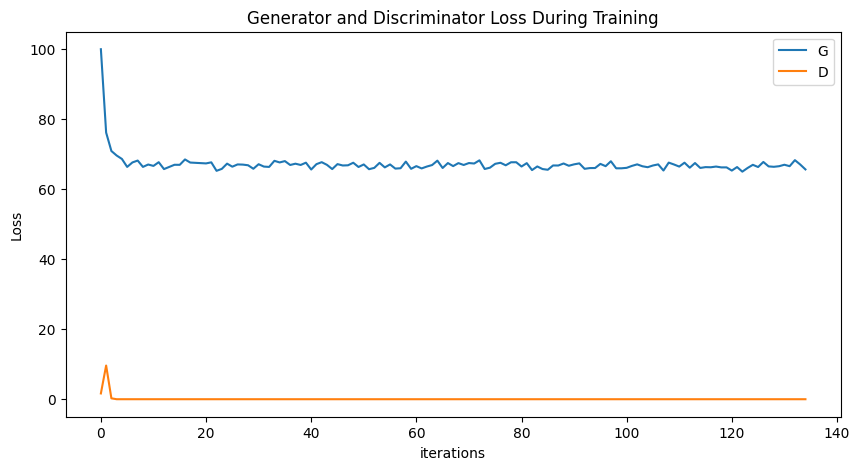

In [24]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

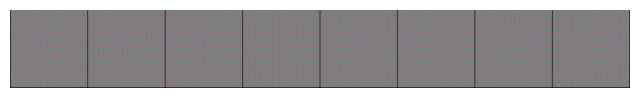

In [25]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [26]:
import cv2
import numpy as np

def frames_to_video(frames, output_path='temp_video.mp4', fps=30):
    num_frames, height, width = frames.shape[0:3]
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # specify the video codec
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for i in range(num_frames):
        frame = frames[i]
        # Convert the frame range from [-1, 1] (as in Tanh output) to [0, 255]
        frame = (((frame + 1) / 2) * 255).astype(np.uint8)
        out.write(frame)

    out.release()
    
fake_video = fake[0].detach().cpu().numpy()  # Take one generated video from the batch
frames_to_video(fake_video, 'temp_video.mp4')



In [27]:
from IPython.display import Video

Video("temp_video.mp4")

# Transformers

In [28]:
# transformers taken from Aksan et al 2021
# https://github.com/eth-ait/motion-transformer
# body pose data deep inertial poser https://dip.is.tue.mpg.de/download.php

In [29]:
# https://docs.ultralytics.com/modes/predict/#keypoints

for person in result:
   print(person.keypoints.xy)

tensor([[[ 577.5127,  226.0952],
         [ 609.5530,  193.1802],
         [ 538.8023,  200.8163],
         [ 664.4314,  223.4404],
         [ 494.3451,  244.6249],
         [ 739.1966,  444.2262],
         [ 451.9687,  460.3725],
         [ 790.5558,  727.5428],
         [ 390.3636,  740.5133],
         [ 773.8361,  973.3709],
         [ 382.7873,  966.4279],
         [ 678.3329,  914.1348],
         [ 496.6207,  915.4054],
         [ 650.1769, 1297.2836],
         [ 509.3653, 1289.0243],
         [ 634.1794, 1611.8878],
         [ 527.6819, 1597.6074]]])


In [30]:
# GAN